In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent, mod_state):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_curr_state = action_user_one_hot[:]
        mod_curr_state = np.array(mod_curr_state)
        mod_state.append(mod_curr_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
prev_timesteps = 4

class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (None,6))    #curr_x, curr_y, target_x, target_y
        x = SimpleRNN(16)(input_A)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        state_temp = np.array(state)[-4:]
        action_mod = self.exp_policy(state_temp)
        action_user = np.argmax(state[:4])
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        temp_next_state = next_dir_one_hot[:]
        temp_next_state = np.array(temp_next_state)
        next_state = deepcopy(state)
        next_state.append(temp_next_state)
        
        next_state = np.array(next_state)[-4:]
        state = np.array(state)[-4:]
        
        if next_state.shape[0]==4 and state.shape[0]==4:
            self.replay_buffer.append(state, action_mod-1, reward_mod, next_state, done)

        
        return new_loc, reward_user, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.9 0.4]
 [0.8 0.9]
 [0.  0.9]
 [0.  0.8]
 [0.3 0.4]
 [0.8 0.3]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

  0%|                                                                              | 20/100000 [00:00<17:34, 94.83it/s]

Mean Reward = -32.0
0


  0%|                                                                           | 103/100000 [00:02<1:07:51, 24.53it/s]

Updated Weights
Mean Reward = -37.67
1


  0%|▏                                                                          | 205/100000 [00:06<1:07:32, 24.62it/s]

Updated Weights
Mean Reward = -37.51
2


  0%|▏                                                                          | 302/100000 [00:12<1:44:02, 15.97it/s]

Updated Weights
Mean Reward = -36.91
3


  0%|▎                                                                          | 402/100000 [00:19<1:56:33, 14.24it/s]

Updated Weights
Mean Reward = -38.06
1


  0%|▍                                                                          | 500/100000 [00:26<1:56:33, 14.23it/s]

Updated Weights
Mean Reward = -37.5
1


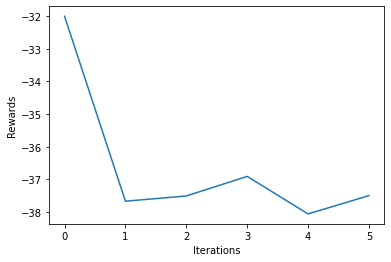

  1%|▍                                                                          | 602/100000 [00:35<2:26:37, 11.30it/s]

Updated Weights
Mean Reward = -37.22
2


  1%|▌                                                                          | 702/100000 [00:44<2:36:36, 10.57it/s]

Updated Weights
Mean Reward = -38.03
1


  1%|▌                                                                          | 802/100000 [00:55<3:09:30,  8.72it/s]

Updated Weights
Mean Reward = -38.5
0


  1%|▋                                                                          | 902/100000 [01:06<3:17:38,  8.36it/s]

Updated Weights
Mean Reward = -37.88
1


  1%|▋                                                                         | 1000/100000 [01:17<3:11:23,  8.62it/s]

Updated Weights
Mean Reward = -37.43
2


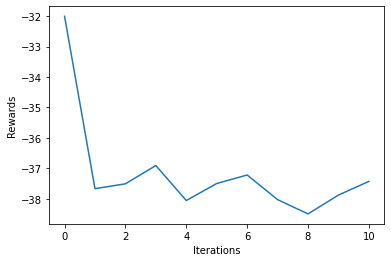

  1%|▊                                                                         | 1102/100000 [01:32<3:57:11,  6.95it/s]

Updated Weights
Mean Reward = -37.35
2


  1%|▉                                                                         | 1202/100000 [01:48<3:54:43,  7.02it/s]

Updated Weights
Mean Reward = -38.72
0


  1%|▉                                                                         | 1301/100000 [02:03<4:26:50,  6.16it/s]

Updated Weights
Mean Reward = -37.18
3


  1%|█                                                                         | 1402/100000 [02:19<4:11:19,  6.54it/s]

Updated Weights
Mean Reward = -38.48
0


  2%|█                                                                         | 1500/100000 [02:34<4:19:05,  6.34it/s]

Updated Weights
Mean Reward = -36.28
5


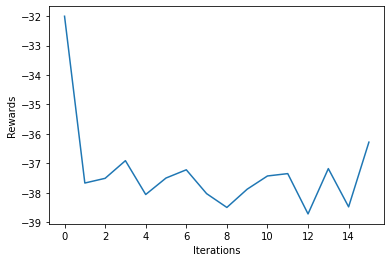

  2%|█▏                                                                        | 1602/100000 [02:50<4:27:24,  6.13it/s]

Updated Weights
Mean Reward = -37.38
2


  2%|█▎                                                                        | 1702/100000 [03:06<3:34:03,  7.65it/s]

Updated Weights
Mean Reward = -38.16
1


  2%|█▎                                                                        | 1802/100000 [03:19<3:56:24,  6.92it/s]

Updated Weights
Mean Reward = -38.51
1


  2%|█▍                                                                        | 1902/100000 [03:34<4:01:37,  6.77it/s]

Updated Weights
Mean Reward = -37.73
2


  2%|█▍                                                                        | 2000/100000 [03:48<3:56:09,  6.92it/s]

Updated Weights
Mean Reward = -38.44
1


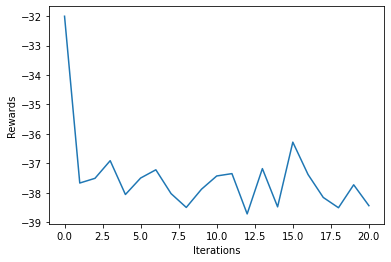

  2%|█▌                                                                        | 2102/100000 [04:03<4:18:02,  6.32it/s]

Updated Weights
Mean Reward = -37.54
3


  2%|█▋                                                                        | 2202/100000 [04:19<4:17:46,  6.32it/s]

Updated Weights
Mean Reward = -38.27
1


  2%|█▋                                                                        | 2302/100000 [04:35<5:08:42,  5.27it/s]

Updated Weights
Mean Reward = -38.27
1


  2%|█▊                                                                        | 2402/100000 [04:54<4:21:38,  6.22it/s]

Updated Weights
Mean Reward = -39.18
0


  2%|█▊                                                                        | 2500/100000 [05:10<4:30:29,  6.01it/s]

Updated Weights
Mean Reward = -37.72
3


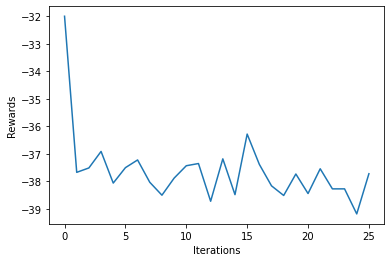

  3%|█▉                                                                        | 2602/100000 [05:28<4:53:51,  5.52it/s]

Updated Weights
Mean Reward = -37.97
2


  3%|█▉                                                                        | 2702/100000 [05:46<4:30:55,  5.99it/s]

Updated Weights
Mean Reward = -38.84
1


  3%|██                                                                        | 2801/100000 [06:04<4:49:46,  5.59it/s]

Updated Weights
Mean Reward = -38.65
1


  3%|██▏                                                                       | 2902/100000 [06:22<4:47:47,  5.62it/s]

Updated Weights
Mean Reward = -38.65
1


  3%|██▏                                                                       | 3000/100000 [06:40<4:29:31,  6.00it/s]

Updated Weights
Mean Reward = -38.04
1


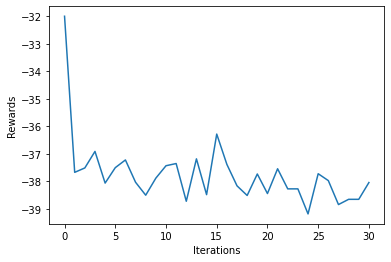

  3%|██▎                                                                       | 3101/100000 [06:59<5:23:17,  5.00it/s]

Updated Weights
Mean Reward = -39.16
0


  3%|██▎                                                                       | 3202/100000 [07:20<5:17:13,  5.09it/s]

Updated Weights
Mean Reward = -38.7
1


  3%|██▍                                                                       | 3301/100000 [07:41<5:51:35,  4.58it/s]

Updated Weights
Mean Reward = -39.22
0


  3%|██▌                                                                       | 3402/100000 [08:02<5:41:48,  4.71it/s]

Updated Weights
Mean Reward = -38.47
1


  4%|██▌                                                                       | 3500/100000 [08:23<5:35:14,  4.80it/s]

Updated Weights
Mean Reward = -37.88
2


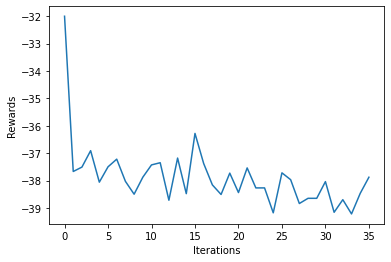

  4%|██▋                                                                       | 3601/100000 [08:45<5:41:11,  4.71it/s]

Updated Weights
Mean Reward = -38.59
1


  4%|██▋                                                                       | 3701/100000 [09:11<7:40:14,  3.49it/s]

Updated Weights
Mean Reward = -38.66
1


  4%|██▊                                                                       | 3801/100000 [09:37<6:42:25,  3.98it/s]

Updated Weights
Mean Reward = -37.79
2


  4%|██▉                                                                       | 3901/100000 [10:02<6:32:42,  4.08it/s]

Updated Weights
Mean Reward = -38.83
1


  4%|██▉                                                                       | 4000/100000 [10:28<7:33:36,  3.53it/s]

Updated Weights
Mean Reward = -39.18
0


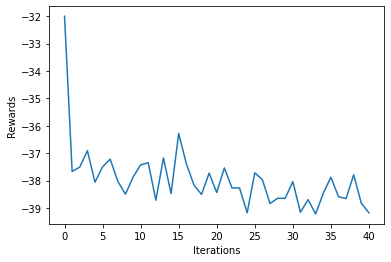

  4%|███                                                                       | 4101/100000 [10:54<6:47:19,  3.92it/s]

Updated Weights
Mean Reward = -39.34
0


  4%|███                                                                       | 4201/100000 [11:19<6:09:05,  4.33it/s]

Updated Weights
Mean Reward = -38.31
2


  4%|███▏                                                                      | 4301/100000 [11:45<6:57:29,  3.82it/s]

Updated Weights
Mean Reward = -38.16
2


  4%|███▎                                                                      | 4401/100000 [12:11<6:54:16,  3.85it/s]

Updated Weights
Mean Reward = -39.2
0


  4%|███▎                                                                      | 4500/100000 [12:36<6:40:17,  3.98it/s]

Updated Weights
Mean Reward = -39.28
0


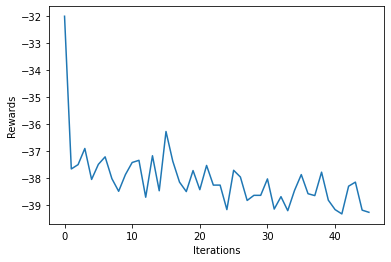

  5%|███▍                                                                      | 4601/100000 [13:01<5:36:53,  4.72it/s]

Updated Weights
Mean Reward = -39.4
0


  5%|███▍                                                                      | 4701/100000 [13:21<5:24:22,  4.90it/s]

Updated Weights
Mean Reward = -39.06
0


  5%|███▌                                                                      | 4802/100000 [13:42<5:32:55,  4.77it/s]

Updated Weights
Mean Reward = -38.73
1


  5%|███▋                                                                      | 4901/100000 [14:03<5:21:02,  4.94it/s]

Updated Weights
Mean Reward = -38.92
0


  5%|███▋                                                                      | 5000/100000 [14:24<5:24:37,  4.88it/s]

Updated Weights
Mean Reward = -37.4
3


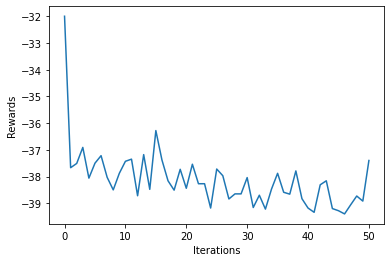

  5%|███▊                                                                      | 5102/100000 [14:45<5:36:11,  4.70it/s]

Updated Weights
Mean Reward = -37.84
2


  5%|███▊                                                                      | 5201/100000 [15:05<5:36:12,  4.70it/s]

Updated Weights
Mean Reward = -37.17
3


  5%|███▉                                                                      | 5300/100000 [15:27<5:42:06,  4.61it/s]

Updated Weights
Mean Reward = -38.53
1


  5%|███▉                                                                      | 5401/100000 [15:48<5:44:10,  4.58it/s]

Updated Weights
Mean Reward = -38.07
2


  6%|████                                                                      | 5500/100000 [16:09<6:07:31,  4.29it/s]

Updated Weights
Mean Reward = -38.71
1


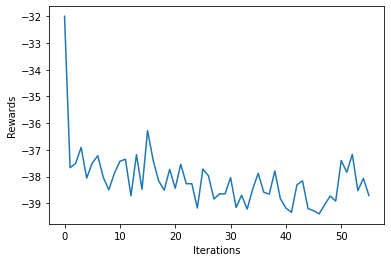

  6%|████▏                                                                     | 5601/100000 [16:31<5:38:11,  4.65it/s]

Updated Weights
Mean Reward = -38.92
0


  6%|████▏                                                                     | 5701/100000 [16:53<5:44:48,  4.56it/s]

Updated Weights
Mean Reward = -38.53
1


  6%|████▎                                                                     | 5801/100000 [17:14<5:48:05,  4.51it/s]

Updated Weights
Mean Reward = -39.3
0


  6%|████▎                                                                     | 5901/100000 [17:36<5:41:58,  4.59it/s]

Updated Weights
Mean Reward = -38.37
1


  6%|████▍                                                                     | 6000/100000 [17:57<5:26:42,  4.80it/s]

Updated Weights
Mean Reward = -38.28
2


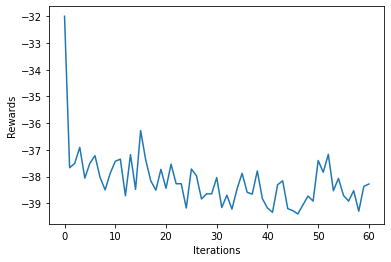

  6%|████▌                                                                     | 6101/100000 [18:19<5:45:13,  4.53it/s]

Updated Weights
Mean Reward = -38.8
1


  6%|████▌                                                                     | 6201/100000 [18:41<6:53:28,  3.78it/s]

Updated Weights
Mean Reward = -37.27
3


  6%|████▋                                                                     | 6301/100000 [19:08<6:56:05,  3.75it/s]

Updated Weights
Mean Reward = -38.3
1


  6%|████▋                                                                     | 6401/100000 [19:36<7:27:58,  3.48it/s]

Updated Weights
Mean Reward = -38.92
0


  6%|████▊                                                                     | 6500/100000 [20:04<7:27:56,  3.48it/s]

Updated Weights
Mean Reward = -37.87
2


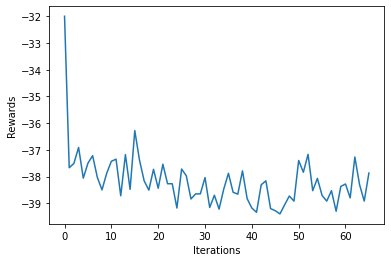

  7%|████▉                                                                     | 6601/100000 [20:33<7:25:18,  3.50it/s]

Updated Weights
Mean Reward = -38.15
2


  7%|████▉                                                                     | 6701/100000 [21:01<7:27:59,  3.47it/s]

Updated Weights
Mean Reward = -38.14
2


  7%|█████                                                                     | 6801/100000 [21:29<7:19:55,  3.53it/s]

Updated Weights
Mean Reward = -36.97
3


  7%|█████                                                                     | 6901/100000 [21:58<7:25:21,  3.48it/s]

Updated Weights
Mean Reward = -38.79
1


  7%|█████▏                                                                    | 7000/100000 [22:26<7:27:31,  3.46it/s]

Updated Weights
Mean Reward = -37.7
2


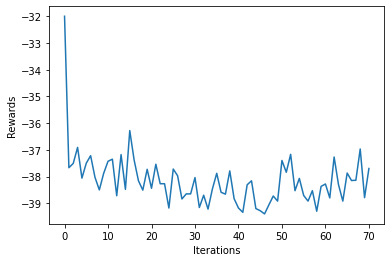

  7%|█████▎                                                                    | 7101/100000 [22:53<5:58:39,  4.32it/s]

Updated Weights
Mean Reward = -38.6
1


  7%|█████▎                                                                    | 7201/100000 [23:15<5:28:45,  4.70it/s]

Updated Weights
Mean Reward = -38.24
2


  7%|█████▍                                                                    | 7301/100000 [23:37<5:49:20,  4.42it/s]

Updated Weights
Mean Reward = -38.53
1


  7%|█████▍                                                                    | 7401/100000 [24:00<5:52:58,  4.37it/s]

Updated Weights
Mean Reward = -38.74
0


  8%|█████▌                                                                    | 7500/100000 [24:23<7:35:33,  3.38it/s]

Updated Weights
Mean Reward = -39.06
0


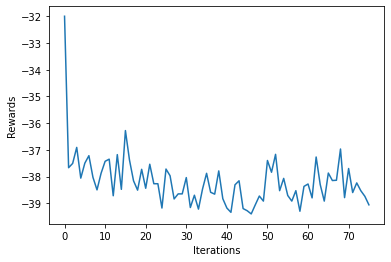

  8%|█████▌                                                                    | 7601/100000 [24:48<5:49:54,  4.40it/s]

Updated Weights
Mean Reward = -37.61
3


  8%|█████▋                                                                    | 7701/100000 [25:11<5:46:31,  4.44it/s]

Updated Weights
Mean Reward = -38.39
1


  8%|█████▊                                                                    | 7801/100000 [25:33<5:43:38,  4.47it/s]

Updated Weights
Mean Reward = -37.23
2


  8%|█████▊                                                                    | 7901/100000 [25:55<5:37:58,  4.54it/s]

Updated Weights
Mean Reward = -36.8
3


  8%|█████▉                                                                    | 8000/100000 [26:17<5:38:46,  4.53it/s]

Updated Weights
Mean Reward = -38.14
2


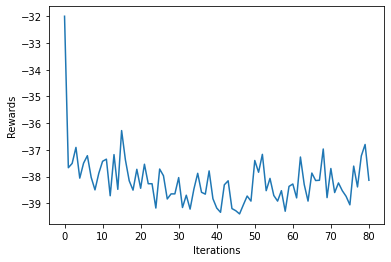

  8%|█████▉                                                                    | 8101/100000 [26:40<5:51:39,  4.36it/s]

Updated Weights
Mean Reward = -38.67
1


  8%|██████                                                                    | 8201/100000 [27:03<5:48:36,  4.39it/s]

Updated Weights
Mean Reward = -38.49
1


  8%|██████▏                                                                   | 8301/100000 [27:26<5:51:08,  4.35it/s]

Updated Weights
Mean Reward = -39.26
0


  8%|██████▏                                                                   | 8401/100000 [27:48<5:48:02,  4.39it/s]

Updated Weights
Mean Reward = -38.98
0


  8%|██████▎                                                                   | 8500/100000 [28:11<5:54:46,  4.30it/s]

Updated Weights
Mean Reward = -38.13
2


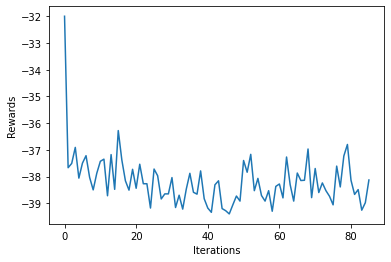

  9%|██████▎                                                                   | 8601/100000 [28:35<5:44:59,  4.42it/s]

Updated Weights
Mean Reward = -39.2
0


  9%|██████▍                                                                   | 8701/100000 [29:01<7:23:42,  3.43it/s]

Updated Weights
Mean Reward = -38.09
1


  9%|██████▌                                                                   | 8801/100000 [29:31<7:51:58,  3.22it/s]

Updated Weights
Mean Reward = -37.95
3


  9%|██████▌                                                                   | 8901/100000 [30:01<7:54:26,  3.20it/s]

Updated Weights
Mean Reward = -38.81
1


  9%|██████▋                                                                   | 9000/100000 [30:31<7:25:01,  3.41it/s]

Updated Weights
Mean Reward = -38.92
1


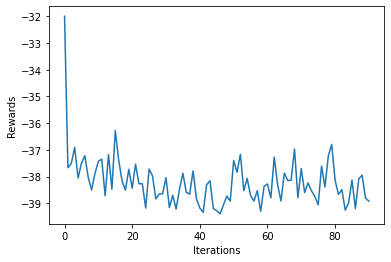

  9%|██████▋                                                                   | 9101/100000 [31:01<6:36:53,  3.82it/s]

Updated Weights
Mean Reward = -38.29
2


  9%|██████▊                                                                   | 9201/100000 [31:37<9:23:04,  2.69it/s]

Updated Weights
Mean Reward = -38.61
1


  9%|██████▉                                                                   | 9301/100000 [32:14<9:12:33,  2.74it/s]

Updated Weights
Mean Reward = -38.81
1


  9%|██████▉                                                                   | 9401/100000 [32:50<9:21:05,  2.69it/s]

Updated Weights
Mean Reward = -38.74
1


 10%|███████                                                                   | 9500/100000 [33:19<5:48:15,  4.33it/s]

Updated Weights
Mean Reward = -39.32
0


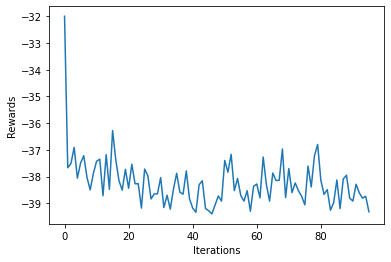

 10%|███████                                                                   | 9601/100000 [33:43<5:46:14,  4.35it/s]

Updated Weights
Mean Reward = -38.69
1


 10%|███████▏                                                                  | 9701/100000 [34:06<5:41:58,  4.40it/s]

Updated Weights
Mean Reward = -39.46
0


 10%|███████▎                                                                  | 9801/100000 [34:28<5:45:39,  4.35it/s]

Updated Weights
Mean Reward = -37.86
2


 10%|███████▎                                                                  | 9901/100000 [34:51<5:42:46,  4.38it/s]

Updated Weights
Mean Reward = -38.38
2


 10%|███████▎                                                                 | 10000/100000 [35:14<6:06:58,  4.09it/s]

Updated Weights
Mean Reward = -39.46
0


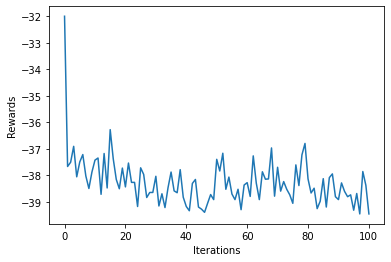

 10%|███████▎                                                                 | 10101/100000 [35:38<5:51:47,  4.26it/s]

Updated Weights
Mean Reward = -39.11
1


 10%|███████▍                                                                 | 10201/100000 [36:01<5:48:07,  4.30it/s]

Updated Weights
Mean Reward = -38.89
1


 10%|███████▌                                                                 | 10301/100000 [36:24<5:31:46,  4.51it/s]

Updated Weights
Mean Reward = -39.11
1


 10%|███████▌                                                                 | 10401/100000 [36:47<5:51:42,  4.25it/s]

Updated Weights
Mean Reward = -39.12
1


 10%|███████▋                                                                 | 10500/100000 [37:10<5:48:58,  4.27it/s]

Updated Weights
Mean Reward = -39.24
0


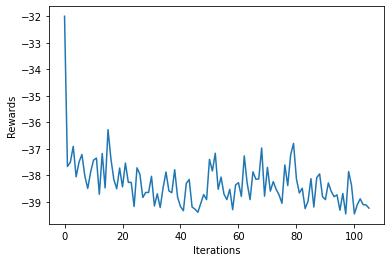

 11%|███████▋                                                                 | 10601/100000 [37:33<5:55:10,  4.19it/s]

Updated Weights
Mean Reward = -39.32
0


 11%|███████▊                                                                 | 10701/100000 [37:57<5:55:29,  4.19it/s]

Updated Weights
Mean Reward = -39.52
0


 11%|███████▉                                                                 | 10801/100000 [38:20<5:44:49,  4.31it/s]

Updated Weights
Mean Reward = -39.68
0


 11%|███████▉                                                                 | 10901/100000 [38:44<6:39:51,  3.71it/s]

Updated Weights
Mean Reward = -39.24
1


 11%|████████                                                                 | 11000/100000 [39:17<8:53:40,  2.78it/s]

Updated Weights
Mean Reward = -39.38
0


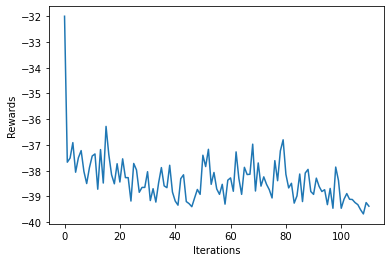

 11%|████████                                                                 | 11101/100000 [39:55<9:18:57,  2.65it/s]

Updated Weights
Mean Reward = -39.54
0


 11%|████████▏                                                                | 11201/100000 [40:33<9:09:24,  2.69it/s]

Updated Weights
Mean Reward = -39.58
0


 11%|████████▏                                                                | 11301/100000 [41:09<9:07:48,  2.70it/s]

Updated Weights
Mean Reward = -38.42
2


 11%|████████▎                                                                | 11401/100000 [41:46<9:12:18,  2.67it/s]

Updated Weights
Mean Reward = -39.78
0


 12%|████████▍                                                                | 11500/100000 [42:23<9:10:08,  2.68it/s]

Updated Weights
Mean Reward = -38.36
2


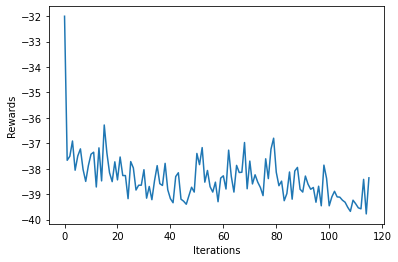

 12%|████████▍                                                                | 11601/100000 [43:01<8:59:26,  2.73it/s]

Updated Weights
Mean Reward = -39.11
1


 12%|████████▌                                                                | 11701/100000 [43:37<7:28:20,  3.28it/s]

Updated Weights
Mean Reward = -39.58
0


 12%|████████▌                                                                | 11801/100000 [44:02<5:43:54,  4.27it/s]

Updated Weights
Mean Reward = -39.52
0


 12%|████████▋                                                                | 11901/100000 [44:26<5:42:06,  4.29it/s]

Updated Weights
Mean Reward = -39.62
0


 12%|████████▊                                                                | 12000/100000 [44:49<5:43:02,  4.28it/s]

Updated Weights
Mean Reward = -38.42
2


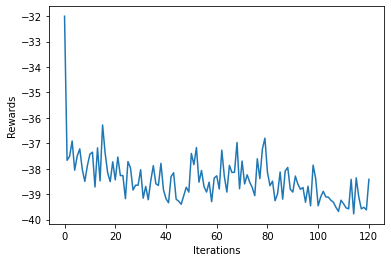

 12%|████████▊                                                                | 12101/100000 [45:12<5:41:46,  4.29it/s]

Updated Weights
Mean Reward = -37.73
3


 12%|████████▉                                                                | 12201/100000 [45:35<5:41:30,  4.28it/s]

Updated Weights
Mean Reward = -39.78
0


 12%|████████▉                                                                | 12301/100000 [45:59<5:41:22,  4.28it/s]

Updated Weights
Mean Reward = -39.64
0


 12%|█████████                                                                | 12401/100000 [46:22<5:37:10,  4.33it/s]

Updated Weights
Mean Reward = -38.77
1


 12%|█████████▏                                                               | 12500/100000 [46:44<5:42:19,  4.26it/s]

Updated Weights
Mean Reward = -38.57
2


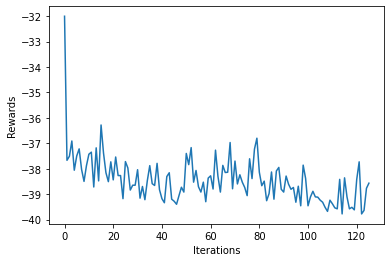

 13%|█████████▏                                                               | 12601/100000 [47:08<5:40:33,  4.28it/s]

Updated Weights
Mean Reward = -37.87
3


 13%|█████████▎                                                               | 12701/100000 [47:31<5:40:23,  4.27it/s]

Updated Weights
Mean Reward = -38.81
1


 13%|█████████▎                                                               | 12801/100000 [47:54<5:39:01,  4.29it/s]

Updated Weights
Mean Reward = -39.58
0


 13%|█████████▍                                                               | 12901/100000 [48:17<5:39:50,  4.27it/s]

Updated Weights
Mean Reward = -39.13
1


 13%|█████████▍                                                               | 13000/100000 [48:41<6:47:08,  3.56it/s]

Updated Weights
Mean Reward = -39.52
0


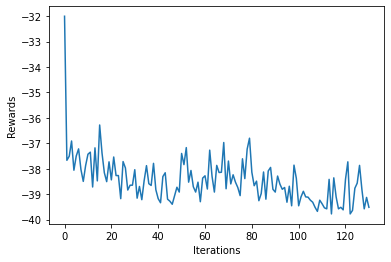

 13%|█████████▌                                                               | 13101/100000 [49:17<8:41:22,  2.78it/s]

Updated Weights
Mean Reward = -39.38
0


 13%|█████████▋                                                               | 13201/100000 [49:54<9:01:57,  2.67it/s]

Updated Weights
Mean Reward = -38.72
1


 13%|█████████▋                                                               | 13301/100000 [50:32<9:02:56,  2.66it/s]

Updated Weights
Mean Reward = -39.64
0


 13%|█████████▊                                                               | 13401/100000 [51:09<9:08:49,  2.63it/s]

Updated Weights
Mean Reward = -39.23
1


 14%|█████████▊                                                               | 13500/100000 [51:46<8:57:26,  2.68it/s]

Updated Weights
Mean Reward = -39.09
1


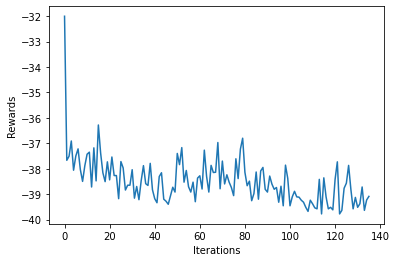

 14%|█████████▉                                                               | 13601/100000 [52:24<9:05:42,  2.64it/s]

Updated Weights
Mean Reward = -38.93
1


 14%|██████████                                                               | 13701/100000 [53:01<8:50:02,  2.71it/s]

Updated Weights
Mean Reward = -38.93
1


 14%|██████████                                                               | 13801/100000 [53:38<8:31:18,  2.81it/s]

Updated Weights
Mean Reward = -39.64
0


 14%|██████████▏                                                              | 13901/100000 [54:05<5:35:16,  4.28it/s]

Updated Weights
Mean Reward = -39.52
0


 14%|██████████▏                                                              | 14000/100000 [54:28<5:35:57,  4.27it/s]

Updated Weights
Mean Reward = -39.03
1


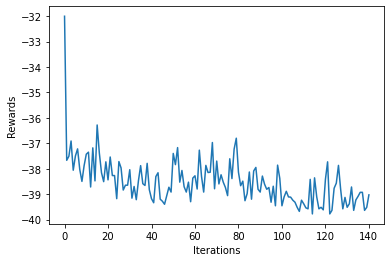

 14%|██████████▎                                                              | 14101/100000 [54:52<5:36:50,  4.25it/s]

Updated Weights
Mean Reward = -39.5
0


 14%|██████████▎                                                              | 14201/100000 [55:15<5:29:37,  4.34it/s]

Updated Weights
Mean Reward = -39.13
1


 14%|██████████▍                                                              | 14301/100000 [55:39<5:32:09,  4.30it/s]

Updated Weights
Mean Reward = -39.13
1


 14%|██████████▌                                                              | 14401/100000 [56:02<5:36:26,  4.24it/s]

Updated Weights
Mean Reward = -39.5
0


 14%|██████████▌                                                              | 14500/100000 [56:25<5:34:12,  4.26it/s]

Updated Weights
Mean Reward = -39.09
1


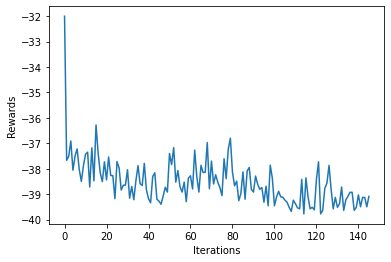

 15%|██████████▋                                                              | 14601/100000 [56:49<5:31:53,  4.29it/s]

Updated Weights
Mean Reward = -39.27
1


 15%|██████████▋                                                              | 14701/100000 [57:12<5:34:03,  4.26it/s]

Updated Weights
Mean Reward = -39.5
0


 15%|██████████▊                                                              | 14801/100000 [57:36<5:37:48,  4.20it/s]

Updated Weights
Mean Reward = -39.54
0


 15%|██████████▉                                                              | 14901/100000 [57:59<5:31:46,  4.27it/s]

Updated Weights
Mean Reward = -39.48
0


 15%|██████████▉                                                              | 15000/100000 [58:22<5:28:07,  4.32it/s]

Updated Weights
Mean Reward = -39.42
0


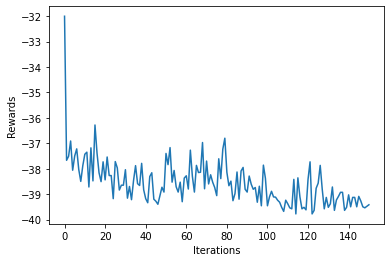

 15%|███████████                                                              | 15101/100000 [58:49<8:07:07,  2.90it/s]

Updated Weights
Mean Reward = -38.87
1


 15%|███████████                                                              | 15201/100000 [59:25<8:46:41,  2.68it/s]

Updated Weights
Mean Reward = -39.12
1


 15%|██████████▊                                                            | 15301/100000 [1:00:03<8:51:02,  2.66it/s]

Updated Weights
Mean Reward = -39.52
0


 15%|██████████▉                                                            | 15401/100000 [1:00:39<8:51:26,  2.65it/s]

Updated Weights
Mean Reward = -38.55
2


 16%|███████████                                                            | 15500/100000 [1:01:16<8:44:47,  2.68it/s]

Updated Weights
Mean Reward = -39.38
0


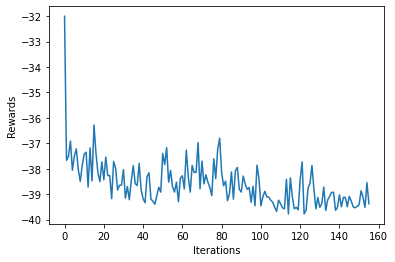

 16%|███████████                                                            | 15601/100000 [1:01:54<8:47:36,  2.67it/s]

Updated Weights
Mean Reward = -39.11
1


 16%|███████████▏                                                           | 15701/100000 [1:02:32<8:49:10,  2.66it/s]

Updated Weights
Mean Reward = -39.66
0


 16%|███████████▏                                                           | 15801/100000 [1:03:09<8:37:02,  2.71it/s]

Updated Weights
Mean Reward = -39.6
0


 16%|███████████▎                                                           | 15901/100000 [1:03:45<8:18:41,  2.81it/s]

Updated Weights
Mean Reward = -39.58
0


 16%|███████████▎                                                           | 16000/100000 [1:04:11<5:28:19,  4.26it/s]

Updated Weights
Mean Reward = -39.5
0


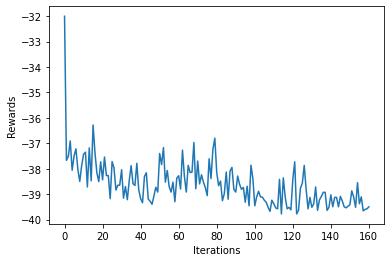

 16%|███████████▍                                                           | 16101/100000 [1:04:34<5:16:56,  4.41it/s]

Updated Weights
Mean Reward = -38.66
2


 16%|███████████▌                                                           | 16201/100000 [1:04:57<5:34:25,  4.18it/s]

Updated Weights
Mean Reward = -39.01
1


 16%|███████████▌                                                           | 16301/100000 [1:05:21<5:29:32,  4.23it/s]

Updated Weights
Mean Reward = -39.66
0


 16%|███████████▋                                                           | 16401/100000 [1:05:44<5:23:13,  4.31it/s]

Updated Weights
Mean Reward = -39.17
1


 16%|███████████▋                                                           | 16500/100000 [1:06:07<5:26:10,  4.27it/s]

Updated Weights
Mean Reward = -39.64
0


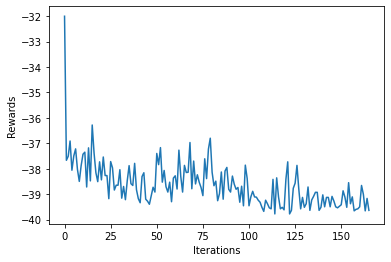

 17%|███████████▊                                                           | 16601/100000 [1:06:31<5:20:36,  4.34it/s]

Updated Weights
Mean Reward = -39.58
0


 17%|███████████▊                                                           | 16701/100000 [1:06:55<5:24:13,  4.28it/s]

Updated Weights
Mean Reward = -39.66
0


 17%|███████████▉                                                           | 16801/100000 [1:07:18<5:27:40,  4.23it/s]

Updated Weights
Mean Reward = -39.07
1


 17%|███████████▉                                                           | 16901/100000 [1:07:41<5:28:25,  4.22it/s]

Updated Weights
Mean Reward = -39.13
1


 17%|████████████                                                           | 17000/100000 [1:08:04<5:23:01,  4.28it/s]

Updated Weights
Mean Reward = -39.62
0


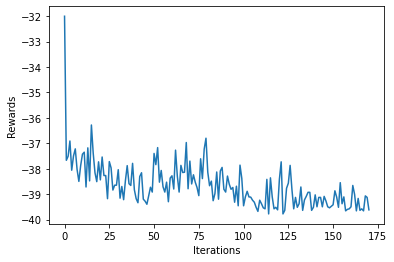

 17%|████████████▏                                                          | 17101/100000 [1:08:28<5:22:30,  4.28it/s]

Updated Weights
Mean Reward = -39.68
0


 17%|████████████▏                                                          | 17201/100000 [1:08:58<8:29:02,  2.71it/s]

Updated Weights
Mean Reward = -39.09
1


 17%|████████████▎                                                          | 17301/100000 [1:09:34<8:47:09,  2.61it/s]

Updated Weights
Mean Reward = -39.72
0


 17%|████████████▎                                                          | 17401/100000 [1:10:12<8:38:24,  2.66it/s]

Updated Weights
Mean Reward = -39.15
1


 18%|████████████▍                                                          | 17500/100000 [1:10:49<8:37:59,  2.65it/s]

Updated Weights
Mean Reward = -39.68
0


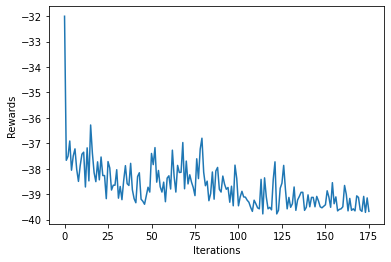

 18%|████████████▍                                                          | 17601/100000 [1:11:27<8:40:39,  2.64it/s]

Updated Weights
Mean Reward = -39.46
0


 18%|████████████▌                                                          | 17701/100000 [1:12:05<8:46:11,  2.61it/s]

Updated Weights
Mean Reward = -39.52
0


 18%|████████████▋                                                          | 17801/100000 [1:12:42<8:41:00,  2.63it/s]

Updated Weights
Mean Reward = -38.95
1


 18%|████████████▋                                                          | 17901/100000 [1:13:19<8:42:38,  2.62it/s]

Updated Weights
Mean Reward = -39.62
0


 18%|████████████▊                                                          | 18000/100000 [1:13:55<7:49:01,  2.91it/s]

Updated Weights
Mean Reward = -39.11
1


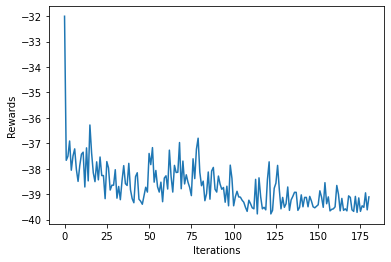

 18%|████████████▊                                                          | 18101/100000 [1:14:19<5:19:40,  4.27it/s]

Updated Weights
Mean Reward = -39.66
0


 18%|████████████▉                                                          | 18201/100000 [1:14:42<5:20:37,  4.25it/s]

Updated Weights
Mean Reward = -39.01
1


 18%|████████████▉                                                          | 18301/100000 [1:15:06<5:20:51,  4.24it/s]

Updated Weights
Mean Reward = -39.54
0


 18%|█████████████                                                          | 18401/100000 [1:15:29<5:19:31,  4.26it/s]

Updated Weights
Mean Reward = -39.6
0


 18%|█████████████                                                          | 18479/100000 [1:15:48<5:34:27,  4.06it/s]


KeyboardInterrupt: 

In [5]:
# user_agent.model.load_weights('user_agent.h5')
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    mod_state = []    #deque(maxlen = prev_timesteps)
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent, mod_state)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()
        mod_agent.train()
    
    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    if epoch>50 and epoch%250==0:
        mod_agent.epsilon*=0.9
        user_agent.epsilon*=0.9

    mean_rewards.append(episode_reward)
    if epoch%100==0:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [ ]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
mod_state = []
while not done and step<max_steps:
    state = np.array(state)
    print(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent, mod_state)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1

In [ ]:
print(done)

In [ ]:
next_states = np.array([mod_agent.replay_buffer.state_history[i] for i in [0,1,2,3,4]])
print(next_states.shape)

In [ ]:
print(next_states)

In [ ]:
np.array(mod_agent.replay_buffer.state_history)